In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict, deque

from livelossplot import PlotLosses
import torch
import torch.nn as nn
import torch.optim as optim

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [19]:
ml_ratings_df = pd.read_csv(os.path.join("data", "movielens_small", "ratings.csv")).rename(columns={'userId': 'user_id', 'movieId': 'item_id'})
ml_movies_df = pd.read_csv(os.path.join("data", "movielens_small", "movies.csv")).rename(columns={'movieId': 'item_id'})
ml_df = pd.merge(ml_ratings_df, ml_movies_df, on='item_id')

# Filter the data to reduce the number of movies
seed = 6789
rng = np.random.RandomState(seed=seed)
left_ids = rng.choice(ml_movies_df['item_id'], size=100, replace=False)

ml_ratings_df = ml_ratings_df.loc[ml_ratings_df['item_id'].isin(left_ids)]
ml_movies_df = ml_movies_df.loc[ml_movies_df['item_id'].isin(left_ids)]
ml_df = ml_df.loc[ml_df['item_id'].isin(left_ids)]

display(HTML(ml_movies_df.head(10).to_html()))

print("Number of interactions left: {}".format(len(ml_ratings_df)))

,item_id,title,genres
118,145,Bad Boys (1995),Action|Comedy|Crime|Drama|Thriller
143,171,Jeffrey (1995),Comedy|Drama
194,228,Destiny Turns on the Radio (1995),Comedy
199,233,Exotica (1994),Drama
230,267,Major Payne (1995),Comedy
313,355,"Flintstones, The (1994)",Children|Comedy|Fantasy
379,435,Coneheads (1993),Comedy|Sci-Fi
419,481,Kalifornia (1993),Drama|Thriller
615,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
737,959,Of Human Bondage (1934),Drama


Number of interactions left: 1170


# Generalized Matrix Factorization (GMF)

In [20]:
from recommenders.recommender import Recommender


class GMFModel(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.fc = nn.Linear(embedding_dim, 1, bias=False)

    def forward(self, x):
        user_ids = x[:, 0]
        item_ids = x[:, 1]
        user_embedding = self.user_embedding(user_ids)
        item_embedding = self.item_embedding(item_ids)
        x = self.fc(user_embedding * item_embedding)
        x = torch.sigmoid(x)

        return x


class GMFRecommender(Recommender):
    """
    General Matrix Factorization recommender as described in:
    - He X., Liao L., Zhang H., Nie L., Hu X., Chua T., Neural Collaborative Filtering, WWW Conference, 2017
    """

    def __init__(self, seed=6789, n_neg_per_pos=5, print_type=None, **params):
        super().__init__()
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.interactions_df = None
        self.item_id_mapping = None
        self.user_id_mapping = None
        self.item_id_reverse_mapping = None
        self.user_id_reverse_mapping = None
        self.r = None
        self.most_popular_items = None
        
        self.nn_model = None
        self.optimizer = None
        
        self.n_neg_per_pos = n_neg_per_pos
        if 'n_epochs' in params:  # number of epochs (each epoch goes through the entire training set)
            self.n_epochs = params['n_epochs']
        else:
            self.n_epochs = 10
        if 'lr' in params:  # learning rate
            self.lr = params['lr']
        else:
            self.lr = 0.01
        if 'weight_decay' in params:  # weight decay (L2 regularization)
            self.weight_decay = params['weight_decay']
        else:
            self.weight_decay = 0.001
        if 'embedding_dim' in params:
            self.embedding_dim = params['embedding_dim']
        else:
            self.embedding_dim = 4
        if 'batch_size' in params:
            self.batch_size = params['batch_size']
        else:
            self.batch_size = 64
        if 'device' in params:
            self.device = params['device']
        else:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        if 'should_recommend_already_bought' in params:
            self.should_recommend_already_bought = params['should_recommend_already_bought']
        else:
            self.should_recommend_already_bought = False
        
        if 'train' in params:
            self.train = params['train']
        else:
            self.train = False
        self.validation_set_size = 0.2
        
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
        torch.manual_seed(seed)
        
        if 'should_save_model' in params:
            self.should_save_model = params['should_save_model']
        self.print_type = print_type

    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.

        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by
            user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined
            by item_id and the item feature columns.
        """

        del users_df, items_df

        # Shift item ids and user ids so that they are consecutive

        unique_item_ids = interactions_df['item_id'].unique()
        self.item_id_mapping = dict(zip(unique_item_ids, list(range(len(unique_item_ids)))))
        self.item_id_reverse_mapping = dict(zip(list(range(len(unique_item_ids))), unique_item_ids))
        unique_user_ids = interactions_df['user_id'].unique()
        self.user_id_mapping = dict(zip(unique_user_ids, list(range(len(unique_user_ids)))))
        self.user_id_reverse_mapping = dict(zip(list(range(len(unique_user_ids))), unique_user_ids))

        interactions_df = interactions_df.copy()
        interactions_df['item_id'] = interactions_df['item_id'].map(self.item_id_mapping)
        interactions_df['user_id'] = interactions_df['user_id'].map(self.user_id_mapping)

        # Get the number of items and users

        self.interactions_df = interactions_df.copy()
        n_users = np.max(interactions_df['user_id']) + 1
        n_items = np.max(interactions_df['item_id']) + 1

        # Get the user-item interaction matrix (mapping to int is necessary because of how iterrows works)
        r = np.zeros(shape=(n_users, n_items))
        for idx, interaction in interactions_df.iterrows():
            r[int(interaction['user_id'])][int(interaction['item_id'])] = 1

        self.r = r
        
        # Indicate positive interactions
        
        interactions_df.loc[:, 'interacted'] = 1

        # Generate negative interactions
        negative_interactions = []

        i = 0
        while i < self.n_neg_per_pos * len(interactions_df):
            sample_size = 1000
            user_ids = self.rng.choice(np.arange(n_users), size=sample_size)
            item_ids = self.rng.choice(np.arange(n_items), size=sample_size)

            j = 0
            while j < sample_size and i < self.n_neg_per_pos * len(interactions_df):
                if r[user_ids[j]][item_ids[j]] == 0:
                    negative_interactions.append([user_ids[j], item_ids[j], 0])
                    i += 1
                j += 1
        
        interactions_df = pd.concat(
            [interactions_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        interactions_df = interactions_df.reset_index(drop=True)
        
        # Initialize losses and loss visualization
        
        if self.print_type is not None and self.print_type == 'live':
            liveloss = PlotLosses()

        training_losses = deque(maxlen=50)
        training_avg_losses = []
        training_epoch_losses = []
        validation_losses = deque(maxlen=50)
        validation_avg_losses = []
        validation_epoch_losses = []
        last_training_total_loss = 0.0
        last_validation_total_loss = 0.0
        
        # Initialize the network
        
        self.nn_model = GMFModel(n_items, n_users, self.embedding_dim, self.seed)
        self.nn_model.train()
        self.nn_model.to(self.device)
        self.optimizer = optim.Adam(self.nn_model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        # Split the data
        
        if self.train:
            interaction_ids = self.rng.permutation(len(interactions_df))
            train_validation_slice_idx = int(len(interactions_df) * (1 - self.validation_set_size))
            training_ids = interaction_ids[:train_validation_slice_idx]
            validation_ids = interaction_ids[train_validation_slice_idx:]
        else:
            interaction_ids = self.rng.permutation(len(interactions_df))
            training_ids = interaction_ids
            validation_ids = []
        
        # Train the model
        
        for epoch in range(self.n_epochs):
            if self.print_type is not None and self.print_type == 'live':
                logs = {}
                
            # Train
            
            training_losses.clear()
            training_total_loss = 0.0
            
            self.rng.shuffle(training_ids)
            
            batch_idx = 0
            n_batches = int(np.ceil(len(training_ids) / self.batch_size))
            
            for batch_idx in range(n_batches):
                
                batch_ids = training_ids[(batch_idx * self.batch_size):((batch_idx + 1) * self.batch_size)]
                
                batch = interactions_df.loc[batch_ids]
                batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long().to(self.device)
                y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float().to(self.device)
                
                # Create responses

                y = self.nn_model(batch_input).clip(0.000001, 0.999999)

                # Define loss and backpropagate

                self.optimizer.zero_grad()
                loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
                
                loss.backward()
                self.optimizer.step()
                
                training_total_loss += loss.item()
                
                if self.print_type is not None and self.print_type == 'text':
                    print("\rEpoch: {}\tBatch: {}\tLast epoch - avg training loss: {:.2f} avg validation loss: {:.2f} loss: {}".format(
                        epoch, batch_idx, last_training_total_loss, last_validation_total_loss, loss), end="")
                
                training_losses.append(loss.item())
                training_avg_losses.append(np.mean(training_losses))
                
            # Validate
            
            if self.train:

                validation_total_loss = 0.0

                batch = interactions_df.loc[validation_ids]
                batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long().to(self.device)
                y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float().to(self.device)

                # Create responses

                y = self.nn_model(batch_input).clip(0.000001, 0.999999)

                # Calculate validation loss

                loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
                validation_total_loss += loss.item()
                
            # Save and print epoch losses
            
            training_last_avg_loss = training_total_loss / len(training_ids)
            
            if self.train:
                validation_last_avg_loss = validation_total_loss / len(validation_ids)

            if self.print_type is not None and self.print_type == 'live' and epoch >= 0:
                # A bound on epoch prevents showing extremely high losses in the first epochs
                logs['loss'] = training_last_avg_loss
                if self.train:
                    logs['val_loss'] = validation_last_avg_loss
                liveloss.update(logs)
                liveloss.send()

        # Find the most popular items for the cold start problem

        offers_count = interactions_df.loc[:, ['item_id', 'user_id']].groupby(by='item_id').count()
        offers_count = offers_count.sort_values('user_id', ascending=False)
        self.most_popular_items = offers_count.index

    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns
        top n_recommendations for each user.

        :param pd.DataFrame users_df: DataFrame with users and their features for which
            recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations
            for each user.
        :rtype: pd.DataFrame
        """

        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]

        # Handle users not in the training data

        # Map item ids

        items_df = items_df.copy()
        items_df = items_df.loc[items_df['item_id'].isin(self.item_id_mapping)]
        items_df['item_id'] = items_df['item_id'].map(self.item_id_mapping)

        # Generate recommendations

        for idx, user in users_df.iterrows():
            recommendations = []

            user_id = user['user_id']

            if user_id in self.user_id_mapping:
                
                mapped_user_id = self.user_id_mapping[user_id]
                
                ids_list = items_df['item_id'].tolist()
                id_to_pos = np.array([0]*len(ids_list))
                for k in range(len(ids_list)):
                    id_to_pos[ids_list[k]] = k
                
                net_input = torch.tensor(list(zip([mapped_user_id]*len(ids_list), ids_list))).to(self.device)
                
                scores = self.nn_model(net_input).flatten().detach().cpu().numpy()
                
                # Choose n recommendations based on highest scores
                if not self.should_recommend_already_bought:
                    x_list = self.interactions_df.loc[
                        self.interactions_df['user_id'] == mapped_user_id]['item_id'].tolist()
                    scores[id_to_pos[x_list]] = -np.inf

                chosen_pos = np.argsort(-scores)[:n_recommendations]

                for item_pos in chosen_pos:
                    recommendations.append(
                        {
                            'user_id': self.user_id_reverse_mapping[mapped_user_id],
                            'item_id': self.item_id_reverse_mapping[ids_list[item_pos]],
                            'score': scores[item_pos]
                        }
                    )
            else:  # For new users recommend most popular items
                for i in range(n_recommendations):
                    recommendations.append(
                        {
                            'user_id': user['user_id'],
                            'item_id': self.item_id_reverse_mapping[self.most_popular_items[i]],
                            'score': 1.0
                        }
                    )

            user_recommendations = pd.DataFrame(recommendations)

            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])

        return self.recommender_df
    
    def get_user_repr(self, user_id):
        mapped_user_id = self.user_id_mapping[user_id]
        return self.nn_model.user_embedding(torch.tensor(mapped_user_id).to(self.device)).detach().cpu().numpy()
    
    def get_item_repr(self, item_id):
        mapped_item_id = self.item_id_mapping[item_id]
        return self.nn_model.item_embedding(torch.tensor(mapped_item_id).to(self.device)).detach().cpu().numpy()

    
class MLPModel(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, hidden_dim, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.fc1 = nn.Linear(2 * embedding_dim, hidden_dim, bias=False)
        self.fc2 = nn.Linear(hidden_dim, int(hidden_dim / 2), bias=True)
        self.fc3 = nn.Linear(int(hidden_dim / 2), 1, bias=True)

    def forward(self, x):
        user = x[:, 0]
        item = x[:, 1]
        user_embedding = self.user_embedding(user)
        item_embedding = self.item_embedding(item)
        x = torch.cat([user_embedding, item_embedding], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x

    
class NeuMFModel(nn.Module):
    def __init__(self, n_items, n_users, gmf_embedding_dim, mlp_embedding_dim, hidden_dim, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)

        # GMF

        self.gmf_user_embedding = nn.Embedding(n_users, gmf_embedding_dim)
        self.gmf_item_embedding = nn.Embedding(n_items, gmf_embedding_dim)

        # MLP

        self.mlp_user_embedding = nn.Embedding(n_users, mlp_embedding_dim)
        self.mlp_item_embedding = nn.Embedding(n_items, mlp_embedding_dim)
        self.mlp_fc1 = nn.Linear(2 * mlp_embedding_dim, hidden_dim, bias=False)
        self.mlp_fc2 = nn.Linear(hidden_dim, int(hidden_dim / 2), bias=False)

        # Merge

        self.fc = nn.Linear(gmf_embedding_dim + int(hidden_dim / 2), 1, bias=False)

    def forward(self, x):
        user = x[:, 0]
        item = x[:, 1]

        # GMF

        gmf_user_embedding = self.gmf_user_embedding(user)
        gmf_item_embedding = self.gmf_item_embedding(item)
        gmf_x = gmf_user_embedding * gmf_item_embedding

        # MLP

        mlp_user_embedding = self.mlp_user_embedding(user)
        mlp_item_embedding = self.mlp_item_embedding(item)
        mlp_x = torch.cat([mlp_user_embedding, mlp_item_embedding], dim=1)
        mlp_x = torch.relu(self.mlp_fc1(mlp_x))
        mlp_x = torch.relu(self.mlp_fc2(mlp_x))

        # Final score

        x = torch.cat([gmf_x, mlp_x], dim=1)
        x = torch.sigmoid(self.fc(x))

        return x

## Quick test of the recommender (training)

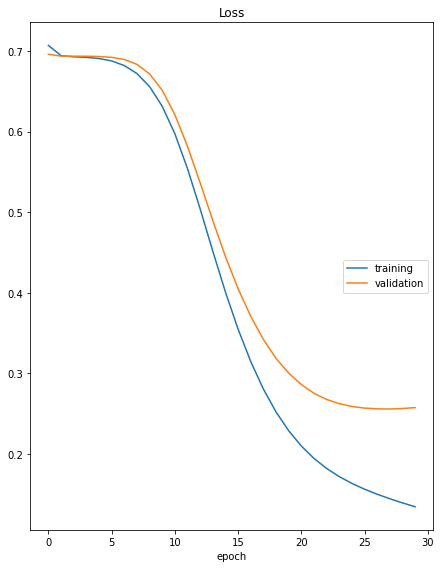

Loss
	training         	 (min:    0.135, max:    0.707, cur:    0.135)
	validation       	 (min:    0.256, max:    0.696, cur:    0.258)


In [21]:
gmf_recommender = GMFRecommender(print_type='live', n_neg_per_pos=10, batch_size=16, 
                                 embedding_dim=6, lr=0.001, weight_decay=0.0001, n_epochs=30, seed=1, train=True)
gmf_recommender.fit(ml_ratings_df, None, ml_movies_df)

## Quick test of the recommender (recommending)

In [22]:
recommendations = gmf_recommender.recommend(pd.DataFrame([[1], [4], [6]], columns=['user_id']), ml_movies_df, 10)

recommendations = pd.merge(recommendations, ml_movies_df, on='item_id', how='left')
print("Recommendations")
display(HTML(recommendations.to_html()))

Recommendations


,user_id,item_id,score,title,genres
0,1,41566,0.978991,"Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)",Adventure|Children|Fantasy
1,1,6502,0.770488,28 Days Later (2002),Action|Horror|Sci-Fi
2,1,4896,0.736372,Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),Adventure|Children|Fantasy
3,1,1914,0.571401,Smoke Signals (1998),Comedy|Drama
4,1,5673,0.534286,Punch-Drunk Love (2002),Comedy|Drama|Romance
5,1,3342,0.386565,Birdy (1984),Drama|War
6,1,104218,0.350539,Grown Ups 2 (2013),Comedy
7,1,267,0.347575,Major Payne (1995),Comedy
8,1,67295,0.332892,Kung Fu Panda: Secrets of the Furious Five (2008),Action|Animation|Children|Comedy
9,1,3089,0.296297,Bicycle Thieves (a.k.a. The Bicycle Thief) (a.k.a. The Bicycle Thieves) (Ladri di biciclette) (1948),Drama


## User and item representations

In [23]:
user_id = 1
user_repr = gmf_recommender.get_user_repr(user_id=user_id)
print("User id={}".format(user_id))
print(user_repr)
print()

print("User watched")
print(ml_df.loc[ml_df['user_id'] == user_id, 'title'].tolist())
print()

print('User history item representations')
for item_id in ml_df.loc[ml_df['user_id'] == user_id, 'item_id'].tolist():
    item_repr = gmf_recommender.get_item_repr(item_id=item_id)
    print("Item id = {}\titem title = {}".format(
        item_id, ml_movies_df.loc[ml_movies_df['item_id'] == item_id, 'title'].iloc[0]))
    print(item_repr)
    scalar_product = np.dot(user_repr, item_repr)
    print("Scalar product={:.6f}".format(scalar_product))
    score = gmf_recommender.nn_model(
        torch.tensor([[gmf_recommender.user_id_mapping[user_id], 
                       gmf_recommender.item_id_mapping[item_id]]]).to(gmf_recommender.device)).flatten().detach().cpu().item()
    print("Score={:.6f}".format(score))
    print()

print("===============")
    
item_id = 145
item_repr = gmf_recommender.get_item_repr(item_id=item_id)
print("Item id = {}\titem title = {}".format(item_id, ml_movies_df.loc[ml_movies_df['item_id'] == item_id, 'title'].iloc[0]))
print(item_repr)
score = np.dot(user_repr, item_repr)
print("Scalar product={:.6f}".format(score))
score = gmf_recommender.nn_model(
    torch.tensor([[gmf_recommender.user_id_mapping[user_id], 
                   gmf_recommender.item_id_mapping[item_id]]]).to(gmf_recommender.device)).flatten().detach().cpu().item()
print("Score={:.6f}".format(score))
print()

item_id = 171
item_repr = gmf_recommender.get_item_repr(item_id=item_id)
print("Item id = {}\titem title = {}".format(item_id, ml_movies_df.loc[ml_movies_df['item_id'] == item_id, 'title'].iloc[0]))
print(item_repr)
score = np.dot(user_repr, item_repr)
print("Scalar product={:.6f}".format(score))
score = gmf_recommender.nn_model(
    torch.tensor([[gmf_recommender.user_id_mapping[user_id], 
                   gmf_recommender.item_id_mapping[item_id]]]).to(gmf_recommender.device)).flatten().detach().cpu().item()
print("Score={:.6f}".format(score))

User id=1
[ 1.583236    1.928833    0.5076821   0.02077339 -0.7576393   0.720875  ]

User watched
['Independence Day (a.k.a. ID4) (1996)', 'Grosse Pointe Blank (1997)', 'Ladyhawke (1985)']

User history item representations
Item id = 780	item title = Independence Day (a.k.a. ID4) (1996)
[-0.08688126 -0.5049163  -0.5540194  -1.7089794   0.36428154 -0.8702819 ]
Scalar product=-2.331578
Score=0.864368

Item id = 1500	item title = Grosse Pointe Blank (1997)
[-0.99034846 -1.2885239  -0.03223765  0.10811037 -1.2086896  -0.84467167]
Scalar product=-3.760575
Score=0.395192

Item id = 3479	item title = Ladyhawke (1985)
[-0.13638315  1.1943792   1.1057804   0.9315033  -0.71073234 -1.4644285 ]
Scalar product=2.151376
Score=0.056009

Item id = 145	item title = Bad Boys (1995)
[-0.4696549   0.4609577   0.35850123 -1.0623587   0.9433856   0.8181307 ]
Scalar product=0.180496
Score=0.155046

Item id = 171	item title = Jeffrey (1995)
[ 0.5504582  -0.712692    1.8113137  -0.12408835 -1.2910577   0.67041

# Training-test split evaluation

In [24]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

In [25]:
gmf_recommender = GMFRecommender(n_neg_per_pos=10, batch_size=16, 
                                 embedding_dim=6, lr=0.001, weight_decay=0.0001, n_epochs=25)

gmf_tts_results = [['GMFRecommender'] + list(evaluate_train_test_split_implicit(
    gmf_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df))]

gmf_tts_results = pd.DataFrame(
    gmf_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommender,0.233766,0.402597,0.506494,0.675325,0.233766,0.330935,0.37255,0.42848


In [26]:
from recommenders.netflix_recommender import NetflixRecommender

netflix_recommender = NetflixRecommender(n_epochs=150)

netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(
    netflix_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df))]

netflix_tts_results = pd.DataFrame(
    netflix_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NetflixRecommender,0.292208,0.538961,0.733766,0.948052,0.292208,0.434289,0.514203,0.583217


In [27]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(
    amazon_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df))]

amazon_tts_results = pd.DataFrame(
    amazon_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,AmazonRecommender,0.181818,0.311688,0.402597,0.551948,0.181818,0.257806,0.294682,0.34147


In [28]:
from recommenders.tfidf_recommender import TFIDFRecommender

tfidf_recommender = TFIDFRecommender()

tfidf_tts_results = [['TFIDFRecommender'] + list(evaluate_train_test_split_implicit(
    tfidf_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df))]

tfidf_tts_results = pd.DataFrame(
    tfidf_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(tfidf_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,TFIDFRecommender,0.025974,0.090909,0.136364,0.318182,0.025974,0.064393,0.083685,0.140799


In [29]:
tts_results = pd.concat([gmf_tts_results, netflix_tts_results, amazon_tts_results, tfidf_tts_results]).reset_index(drop=True)
display(HTML(tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,GMFRecommender,0.233766,0.402597,0.506494,0.675325,0.233766,0.330935,0.372550,0.428480
1,NetflixRecommender,0.292208,0.538961,0.733766,0.948052,0.292208,0.434289,0.514203,0.583217
2,AmazonRecommender,0.181818,0.311688,0.402597,0.551948,0.181818,0.257806,0.294682,0.341470
3,TFIDFRecommender,0.025974,0.090909,0.136364,0.318182,0.025974,0.064393,0.083685,0.140799


# Leave-one-out evaluation

In [30]:
from evaluation_and_testing.testing import evaluate_leave_one_out_implicit

In [ ]:
gmf_recommender = GMFRecommender(n_neg_per_pos=10, batch_size=16, 
                                 embedding_dim=6, lr=0.001, weight_decay=0.0001, n_epochs=25)

gmf_loo_results = [['GMFRecommender'] + list(evaluate_leave_one_out_implicit(
    gmf_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df, max_evals=300, seed=6789))]

gmf_loo_results = pd.DataFrame(
    gmf_loo_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_loo_results.to_html()))

In [ ]:
netflix_recommender = NetflixRecommender(n_epochs=150)

netflix_loo_results = [['NetflixRecommender'] + list(evaluate_leave_one_out_implicit(
    netflix_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df, max_evals=300, seed=6789))]

netflix_loo_results = pd.DataFrame(
    netflix_loo_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_loo_results.to_html()))

In [ ]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_loo_results = [['AmazonRecommender'] + list(evaluate_leave_one_out_implicit(
    amazon_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df, max_evals=300, seed=6789))]

amazon_loo_results = pd.DataFrame(
    amazon_loo_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_loo_results.to_html()))

In [ ]:
tfidf_recommender = TFIDFRecommender()

tfidf_loo_results = [['TFIDFRecommender'] + list(evaluate_leave_one_out_implicit(
    tfidf_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df, max_evals=300, seed=6789))]

tfidf_loo_results = pd.DataFrame(
    tfidf_loo_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(tfidf_loo_results.to_html()))

In [ ]:
loo_results = pd.concat([gmf_loo_results, netflix_loo_results, amazon_loo_results, tfidf_loo_results]).reset_index(drop=True)
display(HTML(loo_results.to_html()))